In [191]:
#paquetes necesarios
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Splitter para partir el dataset en entrenamiento/prueba
from sklearn.model_selection import train_test_split
#Traemos la libreria para usar LASSO
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

### 3. Regularización LASSO

#### Descripción del problema

Trabajaremos con el dataset California Housing del paquete sklearn. La variable objetivo es el valor medio de la vivienda para los distritos de California, expresado en cientos de miles de dólares ($100000). Este conjunto de datos se derivó del censo de EE.UU. de 1990, usando como unidad de censo el grupo de bloques. Un grupo de bloques es la unidad geográfica más pequeña para la que La Oficina del Censo de EE.UU. publica

In [2]:
#Importamos los datos
from sklearn.datasets import fetch_california_housing
#Creamos el recipiente de los datos
california_housing = fetch_california_housing(as_frame=True)

print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [3]:
X = california_housing.data #Asignamos atributos 
Y = california_housing.target #Asignamos etiquetas

In [4]:
#Crorroboramos la estructura del dataset
california_housing.frame.shape
#Exploramos los primeros datos del dataset
california_housing.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Una vez 

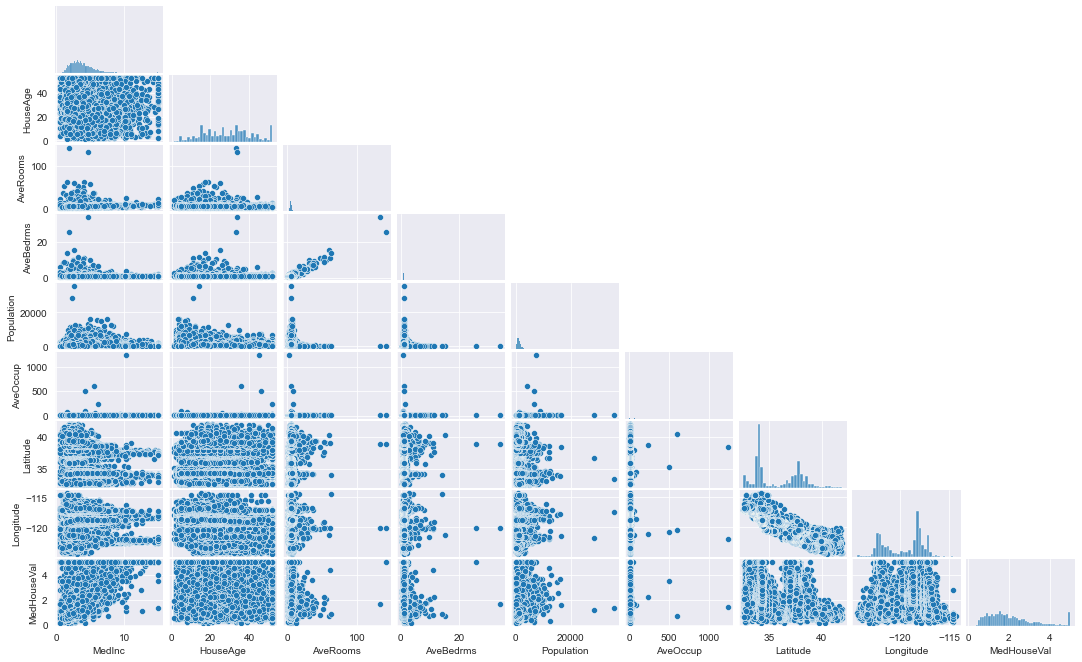

In [189]:
#Construimos la scatter matrix de las variables del dataset
sns.pairplot(data=california_housing.frame, corner = True)
plt.gcf().set_size_inches(15,9)

Al graficar la dispersión entre las variables, es dificil evidenciar visualmente algún tipo de correlación fuerte entre los atributos y el valor medio de una casa; el ingreso medio parece tener una correlación positiva con esta varible dependiente. Sin embargo, se evidencia la presencia de valores atípicos que dificultan el análisis gráfico, además de atributos correlacionados entre ellos: 

- Longitud y Latitud están correlacionados negativamente - a mayor latitud, menor longitud - que corresponde a la naturaleza de la variable como coordenadas de ubicación geográfica; se cuestiona el valor predicitivo de ambas variables al no mostrar correlación aparente con la variable dependiente, pero se debe hacer el cálculo de las correlaciones;
- Por lo demás, el promedio de camas parece estar correlacionado positivamente con el número de habitaciones, lo cual es lo esperado según la intución: más habitaciones, más camas. 

Procedemos a construir una grilla de boxplots para identificar atípicos:


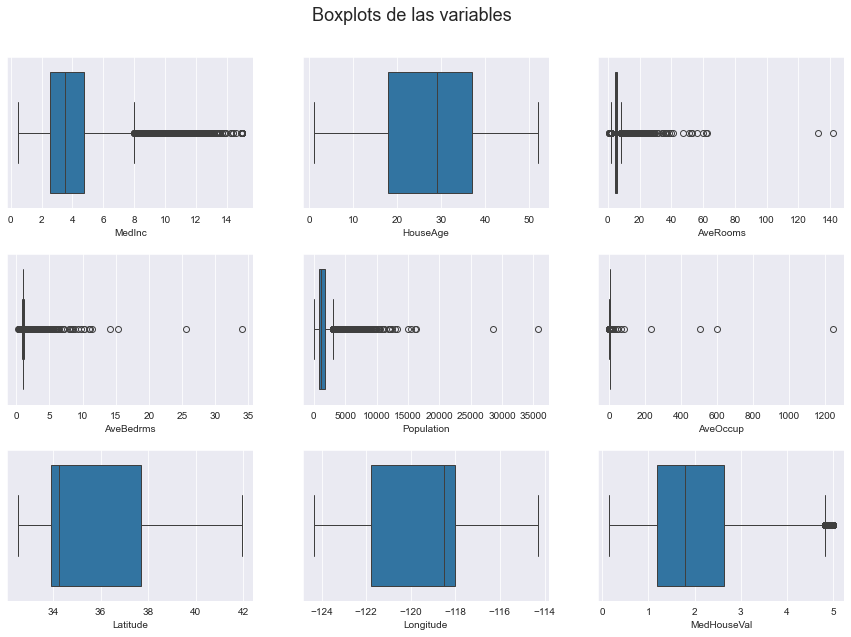

In [185]:
#Enunciamos las columnas
columns = california_housing.frame.columns

#Creamos la grilla de graficación
fig, axes = plt.subplots(nrows=3, ncols= 3, figsize=(15, 10)) 
plt.subplots_adjust(hspace=0.3)
fig.suptitle("Boxplots de las variables", fontsize=18, y=0.95)

for column, ax in zip(columns, axes.ravel()): 
    sns.boxplot(x=column, data=california_housing.frame, ax=ax)#loop que itera sobre cada casilla de la grilla y coloca un gráfico en cada posición
    sns.set_style('darkgrid')
plt.show()

Los gráfico de cajas nos permite ver que existen datos atípicos máximos en todas las variables excepto para HouseAge y las coordenadas Latitude - Longitude. Era de esperarse, de acuerdo con lo definido por el contexto del problema. 

In [188]:
#Permite generar un mapa de calor interactivo
import plotly.express as px

#Calculamos las correlaciones de todas las variables
corr = california_housing.frame.corr()
#Imprimimos las correlaciones
round(corr,2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.00,-0.12,0.33,-0.06,0.00,0.02,-0.08,-0.02,0.69
HouseAge,-0.12,1.00,-0.15,-0.08,-0.30,0.01,0.01,-0.11,0.11
AveRooms,0.33,-0.15,1.00,0.85,-0.07,-0.00,0.11,-0.03,0.15
AveBedrms,-0.06,-0.08,0.85,1.00,-0.07,-0.01,0.07,0.01,-0.05
Population,0.00,-0.30,-0.07,-0.07,1.00,0.07,-0.11,0.10,-0.02
AveOccup,0.02,0.01,-0.00,-0.01,0.07,1.00,0.00,0.00,-0.02
Latitude,-0.08,0.01,0.11,0.07,-0.11,0.00,1.00,-0.92,-0.14
Longitude,-0.02,-0.11,-0.03,0.01,0.10,0.00,-0.92,1.00,-0.05
MedHouseVal,0.69,0.11,0.15,-0.05,-0.02,-0.02,-0.14,-0.05,1.00


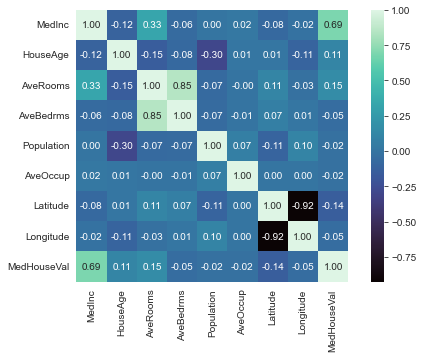

In [179]:
sns.heatmap(corr,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 10},
                 yticklabels=california_housing.frame.columns,
                 xticklabels=california_housing.frame.columns,
                 cmap="mako")
plt.gcf().set_size_inches(8,5)

In [184]:
#Graficamos el mapa de calor interactivo
fig = px.imshow(corr)
fig.show()

Como se corrobora con la matriz de correlaciones, el valor medio de la vivienda tiene una bajísima dependencia lineal negativa con la coordenada de Longitud y es débil para el caso de la Latitud. Esto tiene sentido, dado que estas variables son coordenadas de ubicación cartograficas y que tienden ser mediciones a escala global, que parece tener poca influencia a nivel local en un espacio geográfico limitado como lo es el de California. Además, ambas representan un problema de multicolinealidad para el modelo, al tener una alta correlación negativa. Se propone descartar ambas variables para la construcción del modelo. 

Por otro lado, el cálculo de correlaciones arroja que el valor medio de una vivienda tiene una alta dependencia lineal positiva con el ingreso medio de las viviendas, pero una debil relación positiva con HouseAge y AveRooms, y correlaciones negativas aún más débiles con el resto de las variables.

In [183]:
rang_min =  X.quantile(0.25) - (X.quantile(0.75) - X.quantile(0.25))*1.5
rang_min = pd.DataFrame(rang_min)
rang_max= X.quantile(0.75) + (X.quantile(0.75) - X.quantile(0.25))*1.5
rang_max=pd.DataFrame(rang_max)

In [199]:
alphas = np.linspace(0, 1, 10)
l1 = np.linspace(0, 2, 5)

array([0. , 0.5, 1. , 1.5, 2. ])

In [ ]:
for alpha, j in zip(alphas, l1):
    bestModel = ElasticNet(alpha= alpha, l1_ratio=j)
    bestModel.fit(X,Y)
    
    print(f"L1: {i}, alpha: {j} y el error: {mse}")
